  ORIGIN  MOSTYPE  MAANTHUI  MGEMOMV  MGEMLEEF  MOSHOOFD  MGODRK  MGODPR  \
0  train       33         1        3         2         8       0       5   
1  train       37         1        2         2         8       1       4   
2  train       37         1        2         2         8       0       4   
3  train        9         1        3         3         3       2       3   
4  train       40         1        4         2        10       1       4   

   MGODOV  MGODGE  ...  APERSONG  AGEZONG  AWAOREG  ABRAND  AZEILPL  APLEZIER  \
0       1       3  ...         0        0        0       1        0         0   
1       1       4  ...         0        0        0       1        0         0   
2       2       4  ...         0        0        0       1        0         0   
3       2       4  ...         0        0        0       1        0         0   
4       1       4  ...         0        0        0       1        0         0   

   AFIETS  AINBOED  ABYSTAND  CARAVAN  
0       0       

<ipython-input-11-6da9834b18bb>:39: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  data_preprocessed = pd.concat([data_imputed[numerical_features], data_encoded], axis=1)


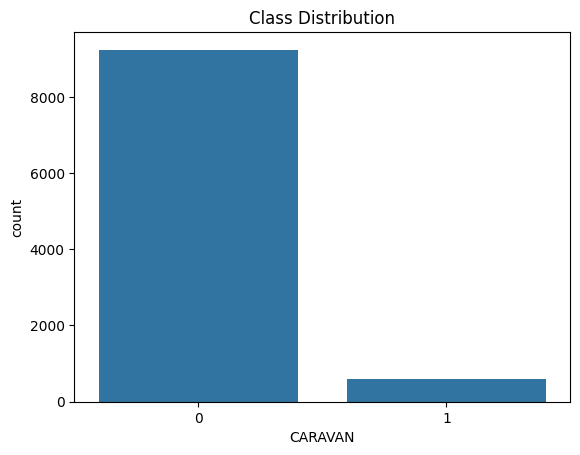

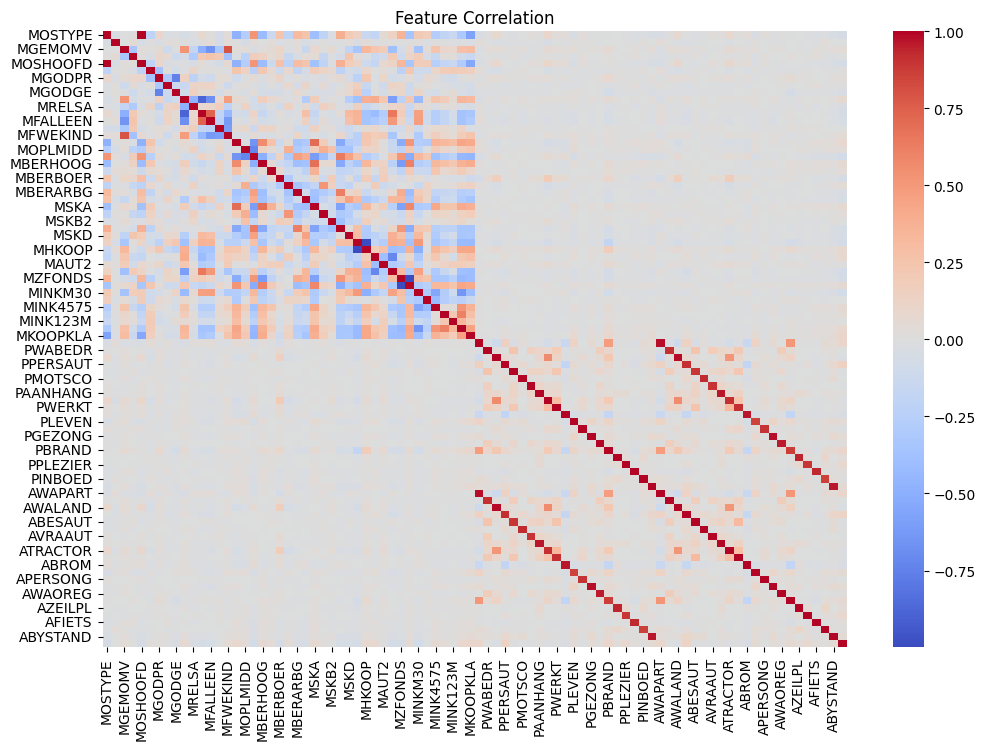

Best features correlated with target: ['CARAVAN', 'PPERSAUT', 'APERSAUT']
CARAVAN
0    9236
1     586
Name: count, dtype: int64
CARAVAN
0    5474
1    5474
Name: count, dtype: int64
Accuracy: 0.914
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95      3762
           1       0.17      0.11      0.14       238

    accuracy                           0.91      4000
   macro avg       0.56      0.54      0.55      4000
weighted avg       0.90      0.91      0.91      4000



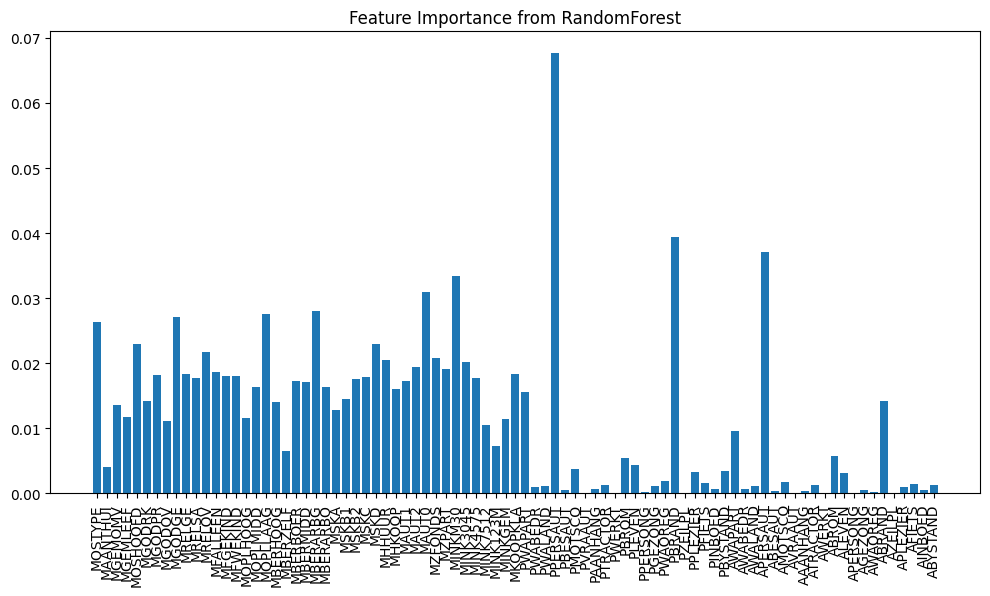

In [ ]:
# Step 1: Data Collection and Loading
import pandas as pd

# Load the dataset
file_path = 'caravan-insurance-challenge.csv'
data = pd.read_csv(file_path)

# Display basic info to ensure data is loaded correctly
print(data.head())
print(data.info())

# Step 2: Data Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Handle missing values
imputer = SimpleImputer(strategy='most_frequent')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Feature selection (remove irrelevant columns)
data_imputed = data_imputed.drop(['ORIGIN'], axis=1)

# Feature scaling
scaler = StandardScaler()
numerical_features = data_imputed.select_dtypes(include=['number']).columns

# Apply scaling only if valid numerical features exist
if len(numerical_features) > 0:
    data_imputed[numerical_features] = scaler.fit_transform(data_imputed[numerical_features])

# Encoding categorical variables (if any)
categorical_features = data_imputed.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(drop='first', sparse_output=False)
data_encoded = pd.DataFrame(encoder.fit_transform(data_imputed[categorical_features]))

# Combine scaled numerical and encoded categorical features
data_preprocessed = pd.concat([data_imputed[numerical_features], data_encoded], axis=1)

# Step 3: Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Check class distribution
sns.countplot(x='CARAVAN', data=data)
plt.title('Class Distribution')
plt.show()

# Correlation matrix
numeric_data = data.select_dtypes(include=['number'])
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

# Get the best features based on correlation with the target
correlation_with_target = correlation_matrix['CARAVAN'].abs().sort_values(ascending=False)
best_features = correlation_with_target[correlation_with_target > 0.1].index.tolist()
print("Best features correlated with target:", best_features)

# Step 4: Address Class Imbalance
from imblearn.over_sampling import SMOTE

# Check class distribution before balancing
print(data['CARAVAN'].value_counts())

# Split data based on 'ORIGIN' column
train_data = data[data['ORIGIN'] == 'train']
test_data = data[data['ORIGIN'] == 'test']

X_train = train_data.drop(['CARAVAN', 'ORIGIN'], axis=1)
y_train = train_data['CARAVAN']
X_test = test_data.drop(['CARAVAN', 'ORIGIN'], axis=1)
y_test = test_data['CARAVAN']

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check class distribution after balancing
print(pd.Series(y_train_balanced).value_counts())

# Step 5: Train Base Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np

base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
meta_features = np.zeros((X_train_balanced.shape[0], len(base_models)))

for i, (name, model) in enumerate(base_models):
    for train_idx, valid_idx in skf.split(X_train_balanced, y_train_balanced):
        X_train_fold, X_valid_fold = X_train_balanced.iloc[train_idx], X_train_balanced.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train_balanced.iloc[train_idx], y_train_balanced.iloc[valid_idx]

        model.fit(X_train_fold, y_train_fold)
        meta_features[valid_idx, i] = model.predict(X_valid_fold)

# Step 6: Generate Meta-Features
# The meta-features have been generated in the previous step for training

# Step 7: Train the Meta-Learner
from sklearn.linear_model import LogisticRegression

meta_model = LogisticRegression()
meta_model.fit(meta_features, y_train_balanced)

# Step 8: Evaluate Model Performance
# Create meta-features for the test set
test_meta_features = np.column_stack([
    model.fit(X_train_balanced, y_train_balanced).predict(X_test) for _, model in base_models
])

# Predict with meta-model
final_predictions = meta_model.predict(test_meta_features)

from sklearn.metrics import accuracy_score, classification_report

print("Accuracy:", accuracy_score(y_test, final_predictions))
print("Classification Report:\n", classification_report(y_test, final_predictions))

# Step 9: Interpretation and Profiling
# Analyze feature importance (RandomForest example)
importances = base_models[0][1].feature_importances_
plt.figure(figsize=(12, 6))
plt.bar(X_train.columns, importances)
plt.title('Feature Importance from RandomForest')
plt.xticks(rotation=90)
plt.show()

# Step 10: Deploy and Monitor
# Deploy: Use frameworks like Flask or FastAPI to serve your model.
# Monitor: Continuously monitor model performance in production and retrain as needed.



  ORIGIN  MOSTYPE  MAANTHUI  MGEMOMV  MGEMLEEF  MOSHOOFD  MGODRK  MGODPR  \
0  train       33         1        3         2         8       0       5   
1  train       37         1        2         2         8       1       4   
2  train       37         1        2         2         8       0       4   
3  train        9         1        3         3         3       2       3   
4  train       40         1        4         2        10       1       4   

   MGODOV  MGODGE  ...  APERSONG  AGEZONG  AWAOREG  ABRAND  AZEILPL  APLEZIER  \
0       1       3  ...         0        0        0       1        0         0   
1       1       4  ...         0        0        0       1        0         0   
2       2       4  ...         0        0        0       1        0         0   
3       2       4  ...         0        0        0       1        0         0   
4       1       4  ...         0        0        0       1        0         0   

   AFIETS  AINBOED  ABYSTAND  CARAVAN  
0       0       

<ipython-input-14-c0c020a41313>:39: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  data_preprocessed = pd.concat([data_imputed[numerical_features], data_encoded], axis=1)


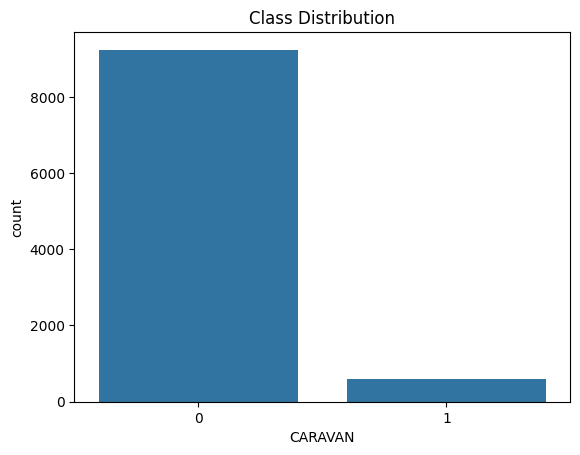

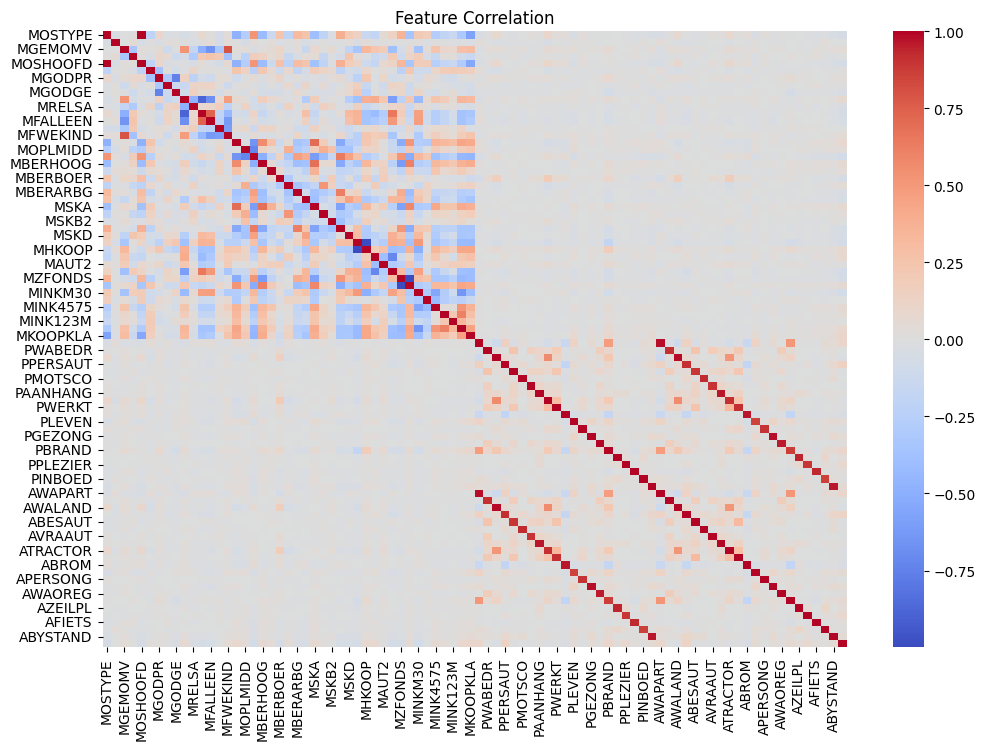

Best features correlated with target: ['CARAVAN', 'PPERSAUT', 'APERSAUT']
CARAVAN
0    9236
1     586
Name: count, dtype: int64
CARAVAN
0    5474
1    5474
Name: count, dtype: int64
Model: rf, Accuracy: 0.9087, MSE: 0.0912
Model: gb, Accuracy: 0.8838, MSE: 0.1163
Model: svm, Accuracy: 0.9327, MSE: 0.0673
Model: nb, Accuracy: 0.6827, MSE: 0.3172

Stacked Model Performance:
Accuracy: 0.9115
MSE: 0.0885

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95      3762
           1       0.18      0.14      0.16       238

    accuracy                           0.91      4000
   macro avg       0.56      0.55      0.56      4000
weighted avg       0.90      0.91      0.91      4000



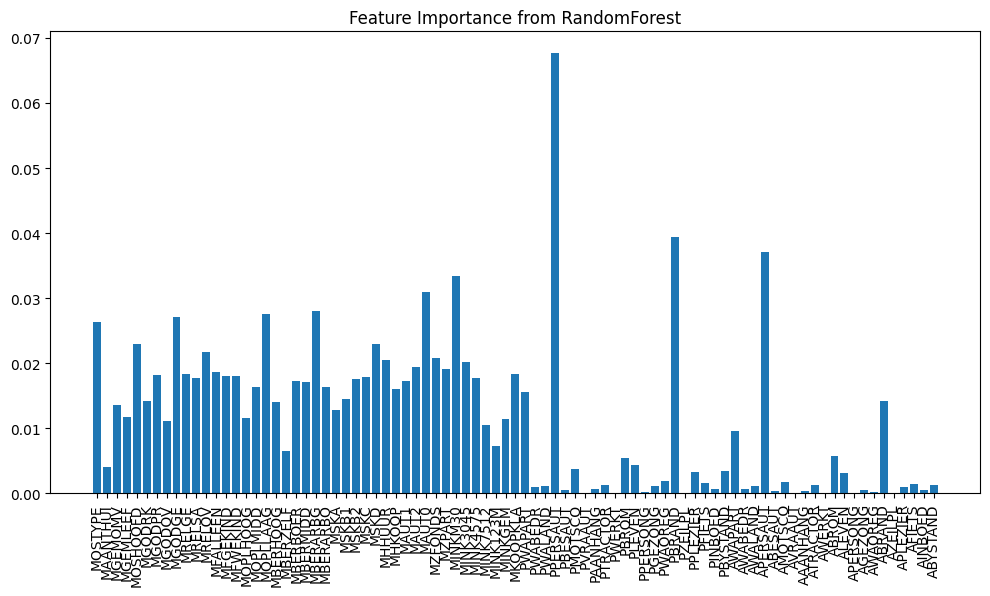

In [ ]:
# Step 1: Data Collection and Loading
import pandas as pd

# Load the dataset
file_path = 'caravan-insurance-challenge.csv'
data = pd.read_csv(file_path)

# Display basic info to ensure data is loaded correctly
print(data.head())
print(data.info())

# Step 2: Data Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Handle missing values
imputer = SimpleImputer(strategy='most_frequent')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Feature selection (remove irrelevant columns)
data_imputed = data_imputed.drop(['ORIGIN'], axis=1)

# Feature scaling
scaler = StandardScaler()
numerical_features = data_imputed.select_dtypes(include=['number']).columns

# Apply scaling only if valid numerical features exist
if len(numerical_features) > 0:
    data_imputed[numerical_features] = scaler.fit_transform(data_imputed[numerical_features])

# Encoding categorical variables (if any)
categorical_features = data_imputed.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(drop='first', sparse_output=False)
data_encoded = pd.DataFrame(encoder.fit_transform(data_imputed[categorical_features]))

# Combine scaled numerical and encoded categorical features
data_preprocessed = pd.concat([data_imputed[numerical_features], data_encoded], axis=1)

# Step 3: Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Check class distribution
sns.countplot(x='CARAVAN', data=data)
plt.title('Class Distribution')
plt.show()

# Correlation matrix
numeric_data = data.select_dtypes(include=['number'])
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

# Get the best features based on correlation with the target
correlation_with_target = correlation_matrix['CARAVAN'].abs().sort_values(ascending=False)
best_features = correlation_with_target[correlation_with_target > 0.1].index.tolist()
print("Best features correlated with target:", best_features)

# Step 4: Address Class Imbalance
from imblearn.over_sampling import SMOTE

# Check class distribution before balancing
print(data['CARAVAN'].value_counts())

# Split data based on 'ORIGIN' column
train_data = data[data['ORIGIN'] == 'train']
test_data = data[data['ORIGIN'] == 'test']

X_train = train_data.drop(['CARAVAN', 'ORIGIN'], axis=1)
y_train = train_data['CARAVAN']
X_test = test_data.drop(['CARAVAN', 'ORIGIN'], axis=1)
y_test = test_data['CARAVAN']

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check class distribution after balancing
print(pd.Series(y_train_balanced).value_counts())

# Step 5: Train Base Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error

base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('svm', SVC(probability=True, random_state=42)),
    ('nb', MultinomialNB())
]

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
meta_features = np.zeros((X_train_balanced.shape[0], len(base_models)))

# Track model performance
model_performance = {}

for i, (name, model) in enumerate(base_models):
    for train_idx, valid_idx in skf.split(X_train_balanced, y_train_balanced):
        X_train_fold, X_valid_fold = X_train_balanced.iloc[train_idx], X_train_balanced.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train_balanced.iloc[train_idx], y_train_balanced.iloc[valid_idx]

        model.fit(X_train_fold, y_train_fold)
        meta_features[valid_idx, i] = model.predict(X_valid_fold)

    # Evaluate the model on the test set
    test_predictions = model.predict(X_test)
    acc = accuracy_score(y_test, test_predictions)
    mse = mean_squared_error(y_test, test_predictions)
    model_performance[name] = {'accuracy': acc, 'mse': mse}
    print(f"Model: {name}, Accuracy: {acc:.4f}, MSE: {mse:.4f}")

# Step 6: Generate Meta-Features
# The meta-features have been generated in the previous step for training

# Step 7: Train the Meta-Learner
from sklearn.linear_model import LogisticRegression

meta_model = LogisticRegression()
meta_model.fit(meta_features, y_train_balanced)

# Step 8: Evaluate Model Performance
# Create meta-features for the test set
test_meta_features = np.column_stack([
    model.fit(X_train_balanced, y_train_balanced).predict(X_test) for _, model in base_models
])

# Predict with meta-model
final_predictions = meta_model.predict(test_meta_features)

meta_acc = accuracy_score(y_test, final_predictions)
meta_mse = mean_squared_error(y_test, final_predictions)

print("\nStacked Model Performance:")
print(f"Accuracy: {meta_acc:.4f}")
print(f"MSE: {meta_mse:.4f}")

from sklearn.metrics import classification_report

print("\nClassification Report:\n", classification_report(y_test, final_predictions))

# Step 9: Interpretation and Profiling
# Analyze feature importance (RandomForest example)
importances = base_models[0][1].feature_importances_
plt.figure(figsize=(12, 6))
plt.bar(X_train.columns, importances)
plt.title('Feature Importance from RandomForest')
plt.xticks(rotation=90)
plt.show()

# Step 10: Deploy and Monitor
# Deploy: Use frameworks like Flask or FastAPI to serve your model.
# Monitor: Continuously monitor model performance in production and retrain as needed.


  ORIGIN  MOSTYPE  MAANTHUI  MGEMOMV  MGEMLEEF  MOSHOOFD  MGODRK  MGODPR  \
0  train       33         1        3         2         8       0       5   
1  train       37         1        2         2         8       1       4   
2  train       37         1        2         2         8       0       4   
3  train        9         1        3         3         3       2       3   
4  train       40         1        4         2        10       1       4   

   MGODOV  MGODGE  ...  APERSONG  AGEZONG  AWAOREG  ABRAND  AZEILPL  APLEZIER  \
0       1       3  ...         0        0        0       1        0         0   
1       1       4  ...         0        0        0       1        0         0   
2       2       4  ...         0        0        0       1        0         0   
3       2       4  ...         0        0        0       1        0         0   
4       1       4  ...         0        0        0       1        0         0   

   AFIETS  AINBOED  ABYSTAND  CARAVAN  
0       0       

<ipython-input-2-f81e9a034fde>:39: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  data_preprocessed = pd.concat([data_imputed[numerical_features], data_encoded], axis=1)


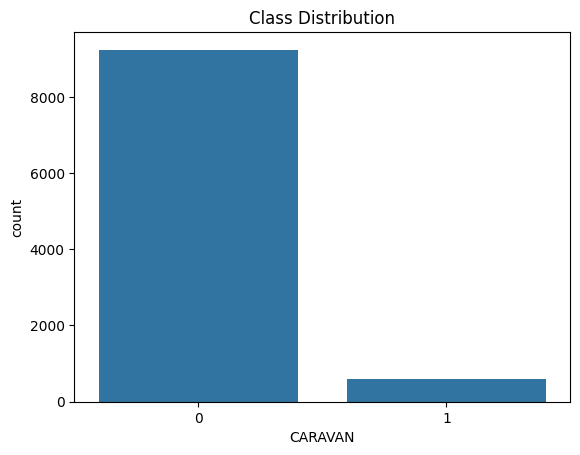

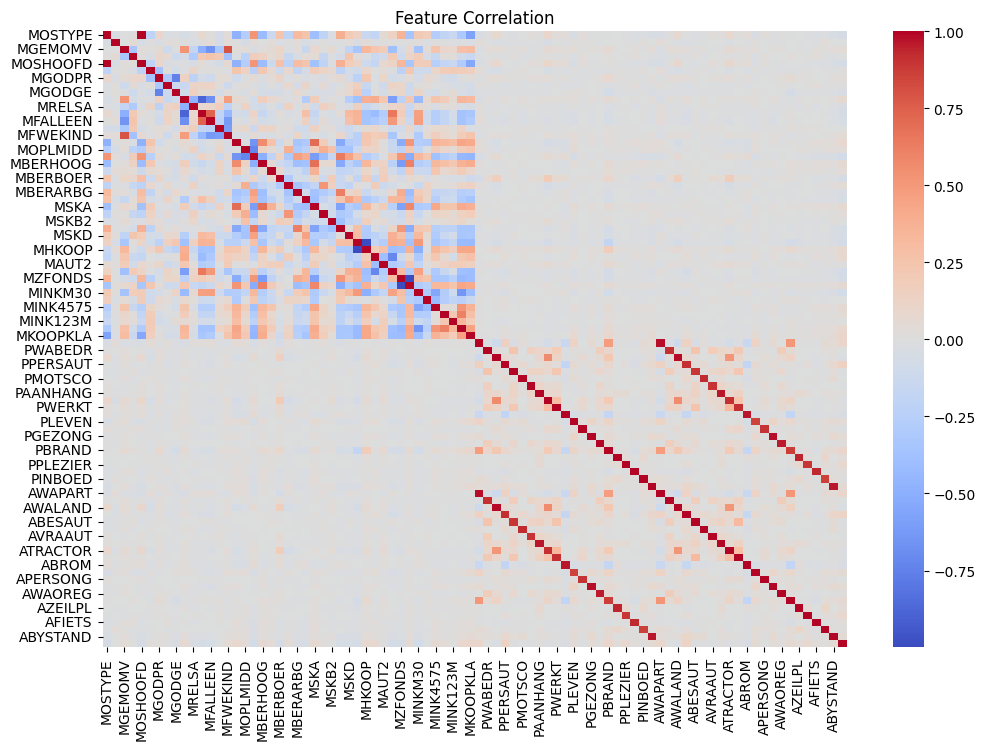

Best features correlated with target: ['CARAVAN', 'PPERSAUT', 'APERSAUT']
CARAVAN
0    9236
1     586
Name: count, dtype: int64
CARAVAN
0    5474
1    5474
Name: count, dtype: int64
Model: rf, Accuracy: 0.9087, MSE: 0.0912
Model: gb, Accuracy: 0.8838, MSE: 0.1163
Model: nb, Accuracy: 0.6827, MSE: 0.3172
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


343/343 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7155 - loss: 0.5449
Epoch 2/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8498 - loss: 0.3416
Epoch 3/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8923 - loss: 0.2703
Epoch 4/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9123 - loss: 0.2261
Epoch 5/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9176 - loss: 0.2083
Epoch 6/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9359 - loss: 0.1723
Epoch 7/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9369 - loss: 0.1623
Epoch 8/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9419 - loss: 0.1569
Epoch 9/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9464 - loss: 0.1370
Epoch 10/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9479 - loss: 0.1356
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model: Neural Network, Accuracy: 0.8480, MSE: 0.1520

Stacked Model Performance:
Accuracy: 0.9140
MSE: 0.0860

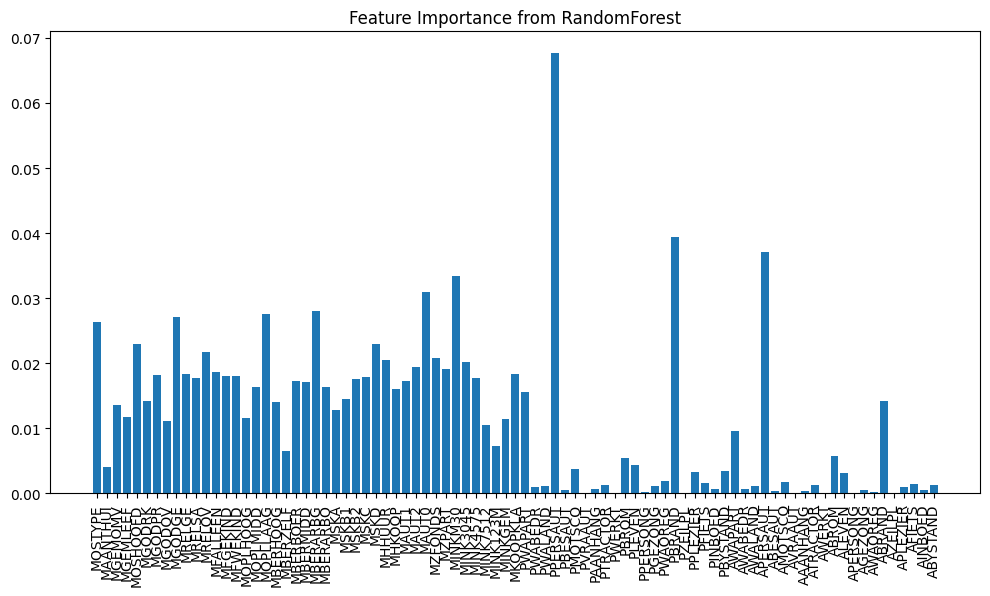

In [ ]:
# Step 1: Data Collection and Loading
import pandas as pd

# Load the dataset
file_path = 'caravan-insurance-challenge.csv'
data = pd.read_csv(file_path)

# Display basic info to ensure data is loaded correctly
print(data.head())
print(data.info())

# Step 2: Data Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Handle missing values
imputer = SimpleImputer(strategy='most_frequent')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Feature selection (remove irrelevant columns)
data_imputed = data_imputed.drop(['ORIGIN'], axis=1)

# Feature scaling
scaler = StandardScaler()
numerical_features = data_imputed.select_dtypes(include=['number']).columns

# Apply scaling only if valid numerical features exist
if len(numerical_features) > 0:
    data_imputed[numerical_features] = scaler.fit_transform(data_imputed[numerical_features])

# Encoding categorical variables (if any)
categorical_features = data_imputed.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(drop='first', sparse_output=False)
data_encoded = pd.DataFrame(encoder.fit_transform(data_imputed[categorical_features]))

# Combine scaled numerical and encoded categorical features
data_preprocessed = pd.concat([data_imputed[numerical_features], data_encoded], axis=1)

# Step 3: Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Check class distribution
sns.countplot(x='CARAVAN', data=data)
plt.title('Class Distribution')
plt.show()

# Correlation matrix
numeric_data = data.select_dtypes(include=['number'])
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

# Get the best features based on correlation with the target
correlation_with_target = correlation_matrix['CARAVAN'].abs().sort_values(ascending=False)
best_features = correlation_with_target[correlation_with_target > 0.1].index.tolist()
print("Best features correlated with target:", best_features)

# Step 4: Address Class Imbalance
from imblearn.over_sampling import SMOTE

# Check class distribution before balancing
print(data['CARAVAN'].value_counts())

# Split data based on 'ORIGIN' column
train_data = data[data['ORIGIN'] == 'train']
test_data = data[data['ORIGIN'] == 'test']

X_train = train_data.drop(['CARAVAN', 'ORIGIN'], axis=1)
y_train = train_data['CARAVAN']
X_test = test_data.drop(['CARAVAN', 'ORIGIN'], axis=1)
y_test = test_data['CARAVAN']

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check class distribution after balancing
print(pd.Series(y_train_balanced).value_counts())

# Step 5: Train Base Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error
from tensorflow import keras
from tensorflow.keras import layers

base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    #('xgb', XGBClassifier(use_label_encoder=False, eval_metric='error', random_state=42)),
    ('nb', MultinomialNB())
]

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
meta_features = np.zeros((X_train_balanced.shape[0], len(base_models)))

# Track model performance
model_performance = {}

for i, (name, model) in enumerate(base_models):
    for train_idx, valid_idx in skf.split(X_train_balanced, y_train_balanced):
        X_train_fold, X_valid_fold = X_train_balanced.iloc[train_idx], X_train_balanced.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train_balanced.iloc[train_idx], y_train_balanced.iloc[valid_idx]

        model.fit(X_train_fold, y_train_fold)
        meta_features[valid_idx, i] = model.predict(X_valid_fold)

    # Evaluate the model on the test set
    test_predictions = model.predict(X_test)
    acc = accuracy_score(y_test, test_predictions)
    mse = mean_squared_error(y_test, test_predictions)
    model_performance[name] = {'accuracy': acc, 'mse': mse}
    print(f"Model: {name}, Accuracy: {acc:.4f}, MSE: {mse:.4f}")

# Add a neural network model
nn_model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_balanced.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the neural network
nn_model.fit(X_train_balanced, y_train_balanced, epochs=10, batch_size=32, verbose=1)

# Evaluate the neural network on the test set
nn_predictions = (nn_model.predict(X_test) > 0.5).astype(int).flatten()
nn_acc = accuracy_score(y_test, nn_predictions)
nn_mse = mean_squared_error(y_test, nn_predictions)
model_performance['nn'] = {'accuracy': nn_acc, 'mse': nn_mse}
print(f"Model: Neural Network, Accuracy: {nn_acc:.4f}, MSE: {nn_mse:.4f}")

# Step 6: Generate Meta-Features
# The meta-features have been generated in the previous step for training

# Step 7: Train the Meta-Learner
from sklearn.linear_model import LogisticRegression

meta_model = LogisticRegression()
meta_model.fit(meta_features, y_train_balanced)

# Step 8: Evaluate Model Performance
# Create meta-features for the test set
test_meta_features = np.column_stack([
    model.fit(X_train_balanced, y_train_balanced).predict(X_test) for _, model in base_models
])

# Predict with meta-model
final_predictions = meta_model.predict(test_meta_features)

meta_acc = accuracy_score(y_test, final_predictions)
meta_mse = mean_squared_error(y_test, final_predictions)

print("\nStacked Model Performance:")
print(f"Accuracy: {meta_acc:.4f}")
print(f"MSE: {meta_mse:.4f}")

from sklearn.metrics import classification_report

print("\nClassification Report:\n", classification_report(y_test, final_predictions))

# Step 9: Interpretation and Profiling
# Analyze feature importance (RandomForest example)
importances = base_models[0][1].feature_importances_
plt.figure(figsize=(12, 6))
plt.bar(X_train.columns, importances)
plt.title('Feature Importance from RandomForest')
plt.xticks(rotation=90)
plt.show()

# Step 10: Deploy and Monitor
# Deploy: Use frameworks like Flask or FastAPI to serve your model.
# Monitor: Continuously monitor model performance in production and retrain as needed.


SVM --> REMOVE?


In [ ]:
# Step 1: Data Loading
import pandas as pd
import numpy as np

file_path = 'caravan-insurance-challenge.csv'
data = pd.read_csv(file_path)


print(f"Shape of the dataset :{ data.shape}")


Shape of the dataset :(9822, 87)


In [ ]:
# display first 10 rows
print(data.head(10))

  ORIGIN  MOSTYPE  MAANTHUI  MGEMOMV  MGEMLEEF  MOSHOOFD  MGODRK  MGODPR  \
0  train       33         1        3         2         8       0       5   
1  train       37         1        2         2         8       1       4   
2  train       37         1        2         2         8       0       4   
3  train        9         1        3         3         3       2       3   
4  train       40         1        4         2        10       1       4   
5  train       23         1        2         1         5       0       5   
6  train       39         2        3         2         9       2       2   
7  train       33         1        2         3         8       0       7   
8  train       33         1        2         4         8       0       1   
9  train       11         2        3         3         3       3       5   

   MGODOV  MGODGE  ...  APERSONG  AGEZONG  AWAOREG  ABRAND  AZEILPL  APLEZIER  \
0       1       3  ...         0        0        0       1        0         0   
1

In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9822 entries, 0 to 9821
Data columns (total 87 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ORIGIN    9822 non-null   object
 1   MOSTYPE   9822 non-null   int64 
 2   MAANTHUI  9822 non-null   int64 
 3   MGEMOMV   9822 non-null   int64 
 4   MGEMLEEF  9822 non-null   int64 
 5   MOSHOOFD  9822 non-null   int64 
 6   MGODRK    9822 non-null   int64 
 7   MGODPR    9822 non-null   int64 
 8   MGODOV    9822 non-null   int64 
 9   MGODGE    9822 non-null   int64 
 10  MRELGE    9822 non-null   int64 
 11  MRELSA    9822 non-null   int64 
 12  MRELOV    9822 non-null   int64 
 13  MFALLEEN  9822 non-null   int64 
 14  MFGEKIND  9822 non-null   int64 
 15  MFWEKIND  9822 non-null   int64 
 16  MOPLHOOG  9822 non-null   int64 
 17  MOPLMIDD  9822 non-null   int64 
 18  MOPLLAAG  9822 non-null   int64 
 19  MBERHOOG  9822 non-null   int64 
 20  MBERZELF  9822 non-null   int64 
 21  MBERBOER  9822

### **Step 2: Data Preprocessing**

In [ ]:
# check for missing values
data.isna().sum()

,0
ORIGIN,0
MOSTYPE,0
MAANTHUI,0
MGEMOMV,0
MGEMLEEF,0
...,...
APLEZIER,0
AFIETS,0
AINBOED,0
ABYSTAND,0


In [ ]:
# We will use Simple imputer class to replace missing values with the most_frequent stratergy
from sklearn.impute import SimpleImputer

imputer_missing = SimpleImputer(strategy='most_frequent')
data_imputed = pd.DataFrame(imputer_missing.fit_transform(data), columns=data.columns)

In [ ]:
# # Feature selection (remove irrelevant columns)
# data_imputed = data_imputed.drop(['ORIGIN'], axis=1)


In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Make instance of Standard Scaler
scaler = StandardScaler()

# we will apply scaling to columns with datatypes as number
numerical_features = data_imputed.select_dtypes(include=['number']).columns

# Apply scaling only if valid numerical features exist
if len(numerical_features) > 0:
    data_imputed[numerical_features] = scaler.fit_transform(data_imputed[numerical_features])

In [ ]:
# Encoding Categorical Columns
from sklearn.preprocessing import OneHotEncoder
# we will apply this encoding to columns with type as object--> 'string' as categories
categorical_features = data_imputed.select_dtypes(include=['object']).columns

# create instance of the OneHotEncoder class
encoder = OneHotEncoder(drop='first', sparse_output=False)

# apply to our dataset --> data_imputed
data_encoded = pd.DataFrame(encoder.fit_transform(data_imputed[categorical_features]))

In [ ]:
# Final Data Preprocessed

# Combine scaled numerical and encoded categorical features
data_preprocessed = pd.concat([data_imputed[numerical_features], data_encoded], axis=1)

<ipython-input-18-71ed31c7cab9>:4: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  data_preprocessed = pd.concat([data_imputed[numerical_features], data_encoded], axis=1)


In [ ]:
print(data_preprocessed)

      0    1    2    3    4    5    6    7    8    9    ...  557  558  559  \
0     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  0.0   
4     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
9817  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
9818  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
9819  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
9820  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
9821  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0   

      560  561  562  563  564  565  566  
0     0.0  0.0  0.0  

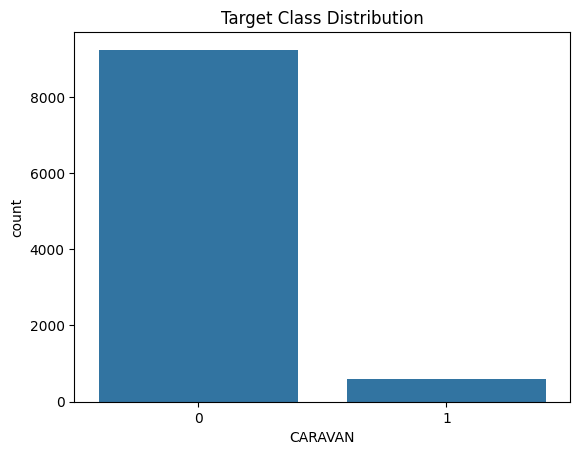

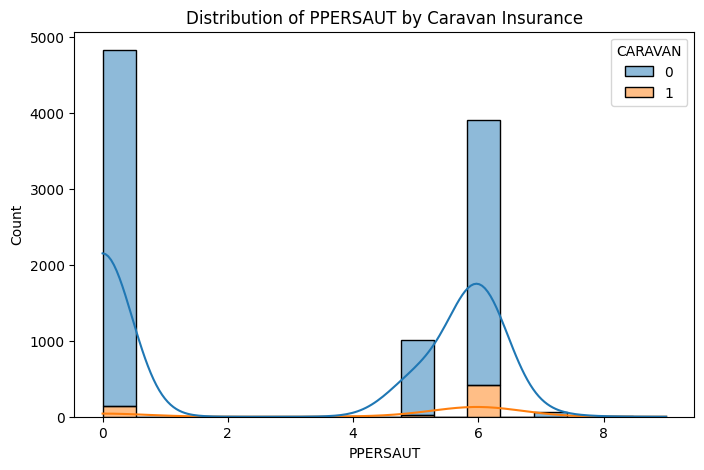

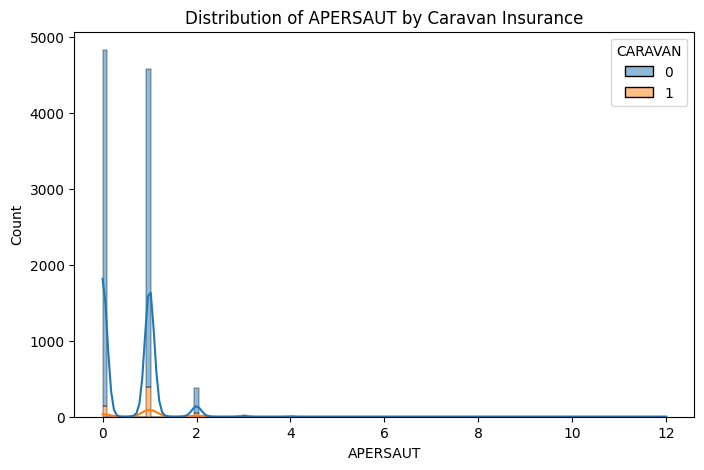

In [ ]:
# Step 3: Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Check class distribution
sns.countplot(x='CARAVAN', data=data)
plt.title('Target Class Distribution')
plt.show()




# this shows imbalance in the dataset

top_features = best_features[1:6]  # Exclude 'CARAVAN' itself
for feature in top_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=data, x=feature, hue='CARAVAN', multiple='stack', kde=True)
    plt.title(f'Distribution of {feature} by Caravan Insurance')
    plt.show()


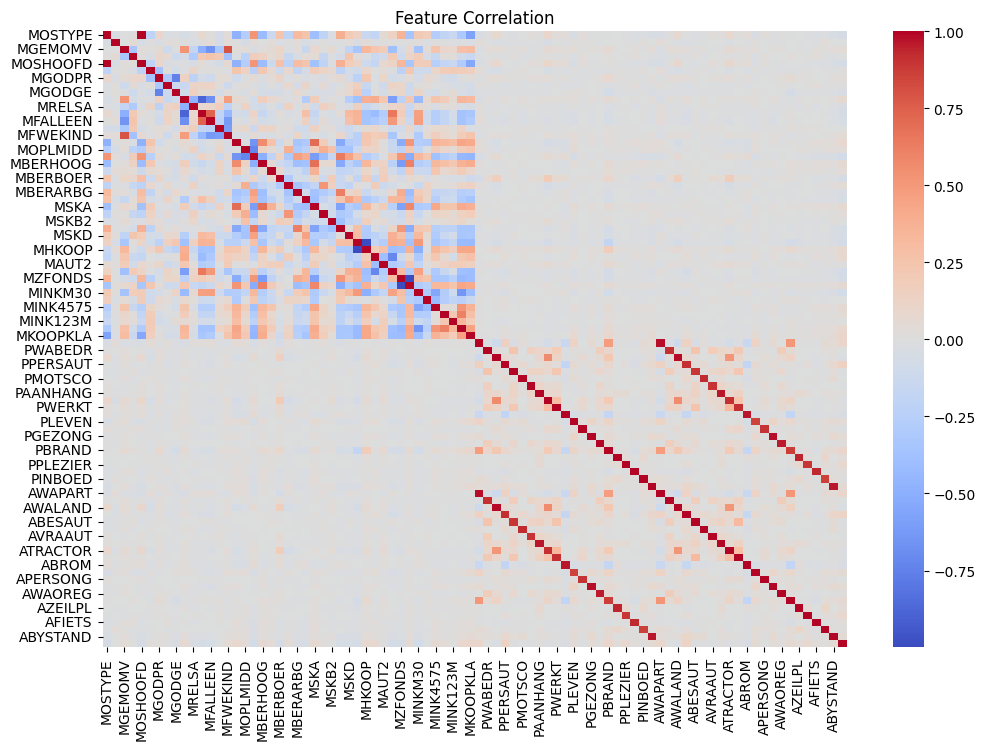

Best features correlated with target: ['CARAVAN', 'PPERSAUT', 'APERSAUT']


In [ ]:
# Correlation matrix
numeric_data = data.select_dtypes(include=['number'])
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

# Get the best features based on correlation with the target
correlation_with_target = correlation_matrix['CARAVAN'].abs().sort_values(ascending=False)
best_features = correlation_with_target[correlation_with_target > 0.1].index.tolist()
print("Best features correlated with target:", best_features)

In [ ]:
# Step 4: Address Class Imbalance
from imblearn.over_sampling import SMOTE

# Check class distribution before balancing
print(data['CARAVAN'].value_counts())

# Split data based on 'ORIGIN' column
train_data = data[data['ORIGIN'] == 'train']
test_data = data[data['ORIGIN'] == 'test']

X_train = train_data.drop(['CARAVAN', 'ORIGIN'], axis=1)
y_train = train_data['CARAVAN']
X_test = test_data.drop(['CARAVAN', 'ORIGIN'], axis=1)
y_test = test_data['CARAVAN']

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check class distribution after balancing
print(pd.Series(y_train_balanced).value_counts())

CARAVAN
0    9236
1     586
Name: count, dtype: int64
CARAVAN
0    5474
1    5474
Name: count, dtype: int64


In [ ]:
# Step 5: Train Base Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error
from tensorflow import keras
from tensorflow.keras import layers

base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    #('xgb', XGBClassifier(use_label_encoder=False, eval_metric='error', random_state=42)),
    ('nb', MultinomialNB())
]

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
meta_features = np.zeros((X_train_balanced.shape[0], len(base_models)))

# Track model performance
model_performance = {}

for i, (name, model) in enumerate(base_models):
    for train_idx, valid_idx in skf.split(X_train_balanced, y_train_balanced):
        X_train_fold, X_valid_fold = X_train_balanced.iloc[train_idx], X_train_balanced.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train_balanced.iloc[train_idx], y_train_balanced.iloc[valid_idx]

        model.fit(X_train_fold, y_train_fold)
        meta_features[valid_idx, i] = model.predict(X_valid_fold)

    # Evaluate the model on the test set
    test_predictions = model.predict(X_test)
    acc = accuracy_score(y_test, test_predictions)
    mse = mean_squared_error(y_test, test_predictions)
    model_performance[name] = {'accuracy': acc, 'mse': mse}
    print(f"Model: {name}, Accuracy: {acc:.4f}, MSE: {mse:.4f}")

# Add a neural network model
nn_model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_balanced.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the neural network
nn_model.fit(X_train_balanced, y_train_balanced, epochs=10, batch_size=32, verbose=1)

# Evaluate the neural network on the test set
nn_predictions = (nn_model.predict(X_test) > 0.5).astype(int).flatten()
nn_acc = accuracy_score(y_test, nn_predictions)
nn_mse = mean_squared_error(y_test, nn_predictions)
model_performance['nn'] = {'accuracy': nn_acc, 'mse': nn_mse}
print(f"Model: Neural Network, Accuracy: {nn_acc:.4f}, MSE: {nn_mse:.4f}")


Model: rf, Accuracy: 0.9087, MSE: 0.0912
Model: gb, Accuracy: 0.8838, MSE: 0.1163
Model: nb, Accuracy: 0.6827, MSE: 0.3172


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7245 - loss: 0.5298
Epoch 2/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8429 - loss: 0.3559
Epoch 3/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8833 - loss: 0.2815
Epoch 4/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8961 - loss: 0.2592
Epoch 5/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9197 - loss: 0.2113
Epoch 6/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9225 - loss: 0.1973
Epoch 7/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9339 - loss: 0.1752
Epoch 8/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9365 - loss: 0.1685
Epoch 9/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9397 - loss: 0.1566
Epoch 10/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9467 - loss: 0.1497
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Model: Neural Network, Accuracy: 0.9275, MSE: 0.0725


In [ ]:
# Step 6: Generate Meta-Features
# The meta-features have been generated in the previous step for training

# Step 7: Train the Meta-Learner
from sklearn.linear_model import LogisticRegression

meta_model = LogisticRegression()
meta_model.fit(meta_features, y_train_balanced)

# Step 8: Evaluate Model Performance
# Create meta-features for the test set
test_meta_features = np.column_stack([
    model.fit(X_train_balanced, y_train_balanced).predict(X_test) for _, model in base_models
])

# Predict with meta-model
final_predictions = meta_model.predict(test_meta_features)

meta_acc = accuracy_score(y_test, final_predictions)
meta_mse = mean_squared_error(y_test, final_predictions)

print("\nStacked Model Performance:")
print(f"Accuracy: {meta_acc:.4f}")
print(f"MSE: {meta_mse:.4f}")

from sklearn.metrics import classification_report

print("\nClassification Report:\n", classification_report(y_test, final_predictions))


Stacked Model Performance:
Accuracy: 0.9140
MSE: 0.0860

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95      3762
           1       0.17      0.11      0.14       238

    accuracy                           0.91      4000
   macro avg       0.56      0.54      0.55      4000
weighted avg       0.90      0.91      0.91      4000

